In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt

dataframe = genfromtxt('train.csv', delimiter=',', skip_header=True)


In [2]:
y, X = dataframe[:,0], dataframe[:, 1:]
y = y.reshape([-1,1])

In [3]:
# Shuffle data set
indices = list(range(len(X)))
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

In [4]:
# Split it into train and validation
n_train = int(0.7 * len(y))

y_train, X_train, y_test, X_test = y[: n_train], X[: n_train, :], y[n_train:], X[n_train:, :]

X_train -= 127
X_train /= 127

X_test  -= 127
X_test /= 127

In [5]:
X_test.shape
y.shape

(42000, 1)

In [6]:
import tensorflow as tf

def dense(input_size, output_size, mean=0.0, stddev=0.001, dtype=tf.float32, activation_type=None):
    weight_tensor = tf.Variable(tf.random_normal(shape=(input_size, output_size),
                                                mean=mean, stddev=stddev, dtype=dtype))
    
    bias_tensor = tf.Variable(tf.zeros(output_size))
    
    def apply_dense(X, keep_prob):
        result = tf.add(tf.matmul(X, weight_tensor), bias_tensor)
        return tf.layers.dropout(activation_type(result), rate=1-keep_prob, training=True) if activation_type != None else tf.layers.dropout(result, rate=1-keep_prob, training=True)

    return apply_dense
        

/home/safwan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
def combine(tensor_one, tensor_two):
    return tf.div(tf.add(tensor_one, tensor_two), 2)

In [23]:
input_ = tf.placeholder(dtype=tf.float32, shape=(None, X_train.shape[1]))
labels = tf.placeholder(dtype=tf.int32, shape=(None, 1))
learning_rate_ph = tf.placeholder(dtype=tf.float32)
keep_prob = tf.placeholder(dtype=tf.float32)

In [24]:
def nn():
    
    #l1 = dense(int(input_.shape[1]), 64, activation_type=tf.nn.relu)(input_, keep_prob)
    input_2d = tf.reshape(input_,[-1,28,28,1])
    l1_1 = tf.layers.conv2d(input_2d,8,3,1,activation=tf.nn.relu)
    l1_2 = tf.layers.max_pooling2d(l1_1,2,2)
    l1_3 = tf.layers.conv2d(l1_2,16,3,1,activation=tf.nn.relu)
    l1_4 = tf.layers.max_pooling2d(l1_3,2,2)
    l1_5 = tf.layers.flatten(l1_4)
    l2 = dense(int(l1_5.shape[1]), 32, activation_type=tf.nn.relu)(l1_5, keep_prob)
    out = dense(int(l2.shape[1]), 10)(l2, keep_prob)
    
    # Define the cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=tf.one_hot(labels,depth=10)))
    
    # Apply an optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_ph).minimize(cost)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_ph).minimize(cost)
    
    return cost, optimizer, out

In [25]:
def get_next_batch(batch_size, X, y):
    for i in range(int(y.shape[0]/batch_size)-1):
        yield X[i: i+batch_size, :] , y[i: i+batch_size]

In [26]:
cost, optimizer, output = nn()

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
# Initialize tensorflow session
init = tf.global_variables_initializer()

epochs = 10
batch_size = 64
num_batches = int(X_train.shape[0]/batch_size)
n_train = int(len(y_train)*0.8)

train_accuracy = []
val_accuracy = []
test_accuracy = []
cost_curr = []

def eval_cost(X, y):
    total_cost = 0
    nb_batches = 0
    for X,y in get_next_batch(256,X,y):
        feed_dict={input_: X, labels: y, learning_rate_ph:current_placeholder_value, keep_prob:1.0}
        total_cost += cost.eval(feed_dict=feed_dict)
        nb_batches += 1
    return total_cost / nb_batches

def eval_accuracy(X,y):
    nb_batches = 0
    total_acc = 0
    for X,y in get_next_batch(256,X,y):
        feed_dict={input_: X, labels: y, learning_rate_ph:current_placeholder_value, keep_prob:1.0}
        y_predicted = np.argmax(output.eval(feed_dict=feed_dict),1)
        total_acc += accuracy_score(y,y_predicted)
        nb_batches += 1
    return total_acc/nb_batches
        

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    #graph = tf.get_default_graph().as_graph_def()
    #print([n for n in graph.node])
    
    #plt.ion()
    # Training cycle
    current_placeholder_value = 0.0001
    
    for epoch in tqdm(range(epochs)):
        # Shuffle data for cross validation
        indices = np.array(range(len(y_train)))
        np.random.shuffle(indices)
        
        train_indices = indices[: n_train]
        val_indices = indices[n_train:]
        
        y_train_fold, X_train_fold, y_val_fold, X_val_fold = y_train[train_indices], X_train[train_indices, :], \
        y_train[val_indices], X_train[val_indices, :]
        
        # Loop over all batches
        for x,y in get_next_batch(batch_size, X_train_fold, y_train_fold):
            sess.run(optimizer, 
                     feed_dict={input_:x, labels:y, learning_rate_ph:current_placeholder_value, keep_prob:0.70})
        
        
        if (epoch+1) % 1 == 0:
            # Find training cost.
            c = eval_cost(X_train_fold, y_train_fold)
            cost_curr.append(c)
            # Find train accuracy
            current_train_acc = eval_accuracy(X_train_fold,y_train_fold)
            train_accuracy.append(current_train_acc)
            # Find the validation accuracy
            current_val_acc = eval_accuracy(X_val_fold, y_val_fold)
            val_accuracy.append(current_val_acc)
            # Find test accuracy
            test_acc = eval_accuracy(X_test, y_test)
            test_accuracy.append(test_acc)
            
            
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
            print("Train Accuracy:", current_train_acc)
            print("Validation Accuracy:", current_val_acc)
            print("Test Accuracy:",test_acc)
            print()
            
            if test_acc > 0.99:
                saver = tf.train.Saver()
                saver.save(sess,'./mnist-acc{}'.format(test_acc*100.0),global_step=epoch+1)
              
    
    print("Optimization Finished!")
    # Find test accuracy
    print("Test Accuracy:",eval_accuracy(X_test, y_test) )

 10%|█         | 1/10 [00:07<01:09,  7.75s/it]

Epoch: 0001 cost= 2.191022446
Train Accuracy: 0.1720920138888889
Validation Accuracy: 0.16462053571428573
Test Accuracy: 0.17130533854166666



 20%|██        | 2/10 [00:15<01:02,  7.81s/it]

Epoch: 0002 cost= 1.210097784
Train Accuracy: 0.7159288194444444
Validation Accuracy: 0.6815476190476191
Test Accuracy: 0.6834309895833334



 30%|███       | 3/10 [00:23<00:54,  7.76s/it]

Epoch: 0003 cost= 0.873672230
Train Accuracy: 0.7618489583333333
Validation Accuracy: 0.7553943452380952
Test Accuracy: 0.7179361979166666



 40%|████      | 4/10 [00:30<00:46,  7.75s/it]

Epoch: 0004 cost= 0.662597444
Train Accuracy: 0.8203993055555555
Validation Accuracy: 0.7674851190476191
Test Accuracy: 0.8001302083333334



 50%|█████     | 5/10 [00:38<00:38,  7.74s/it]

Epoch: 0005 cost= 0.586618531
Train Accuracy: 0.8496961805555555
Validation Accuracy: 0.82421875
Test Accuracy: 0.8302408854166666



 60%|██████    | 6/10 [00:46<00:31,  7.76s/it]

Epoch: 0006 cost= 0.513345718
Train Accuracy: 0.8905381944444445
Validation Accuracy: 0.8917410714285714
Test Accuracy: 0.8634440104166666



 70%|███████   | 7/10 [00:54<00:23,  7.78s/it]

Epoch: 0007 cost= 0.429186926
Train Accuracy: 0.9141493055555555
Validation Accuracy: 0.8389136904761905
Test Accuracy: 0.8868815104166666



 80%|████████  | 8/10 [01:02<00:15,  7.78s/it]

Epoch: 0008 cost= 0.389917200
Train Accuracy: 0.8917100694444444
Validation Accuracy: 0.8586309523809523
Test Accuracy: 0.9039713541666666



 90%|█████████ | 9/10 [01:10<00:07,  7.79s/it]

Epoch: 0009 cost= 0.367682715
Train Accuracy: 0.9171440972222222
Validation Accuracy: 0.8415178571428571
Test Accuracy: 0.888671875



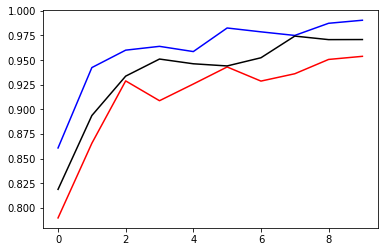

In [30]:
plt.plot(train_accuracy, 'b-', val_accuracy, 'r-', test_accuracy,'k-')
plt.show()

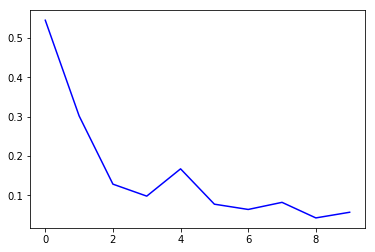

In [31]:
plt.plot(cost_curr, 'b-')
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_test, y_pred=y_predicted_test)

NameError: name 'y_predicted_test' is not defined

In [ ]:
indices = np.where(np.logical_and(y_predicted_test == 7, y_test.squeeze() == 9))[0]
for i in indices:
    plt.figure(figsize=(0.50,0.50))
    plt.imshow(X_test[i].reshape([28,28]),cmap='gray')
    plt.show()